In [1]:
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from datetime import datetime

In [2]:
import jetstream
from jetstream.experimenter import ExperimentCollection
from jetstream.external_config import ExternalConfigCollection
from jetstream.cli import AnalysisExecutor
from jetstream import AnalysisPeriod
from jetstream.bigquery_client import BigQueryClient

In [3]:
from mozanalysis.bq import BigQueryContext
from mozanalysis.experiment import Experiment
from mozanalysis.metrics import Metric
from mozanalysis.metrics.desktop import main, events
from mozanalysis.exposure import ExposureSignal
from mozanalysis.frequentist_stats.bootstrap import compare_branches

# Overview
This notebook reruns the `OVERALL` metrics from the `more-from-mozilla-96` experiment with the new default config, simulating the metrics that would have been calculated, had QCDOU been in the config

# Configure mozanalysis/jetstream classes

In [4]:
# Each experiment has an enrollment period and an observation period.
# We analyze data from each Firefox client *relative* to their enrollment date, as opposed to an absolute calendar date.
NUM_DATES_ENROLLMENT = 7
ANALYSIS_WINDOW_LENGTH = 7
NUM_ANALYSIS_WINDOWS = 4

In [5]:
PROJECT_ID = 'moz-fx-data-bq-data-science'
DATASET_ID = 'dberry'

In [6]:
# Experiment set up
bq_client = BigQueryClient(PROJECT_ID, DATASET_ID)

bq_context = BigQueryContext(
  dataset_id=DATASET_ID,  # BQ tables will be created in this namespace
  project_id=PROJECT_ID
)

experiment = Experiment(
  experiment_slug='more-from-mozilla-96',  # unique ID for Nimbus experiment
  start_date='2022-01-18',
  num_dates_enrollment = NUM_DATES_ENROLLMENT
)
  

In [7]:
ae = AnalysisExecutor(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    bucket='dberry-simulated-aa-tests-temporary',
    date=datetime(2022, 2, 22),
    experiment_slugs=[experiment.experiment_slug]
)

# Manually regenerate the run configs
By default, jetstream pulls the list of metrics from Nimbus, but we want to manually generate it here so it picks up the new QCDOU metric

In [8]:
run_configs = ae._experiment_configs_to_analyse(ExperimentCollection.from_experimenter, ExternalConfigCollection.from_github_repo)

In [9]:
metrics = set([summary.metric.to_mozanalysis_metric() for summary in run_configs[0].metrics[AnalysisPeriod.OVERALL]])

# Generate client-level metric table

In [10]:
%%time
# Fetch data for entire analysis period.
df = experiment.get_single_window_data(
    bq_context,
    metrics,
    last_date_full_data='2022-02-22',
    analysis_start_days=0,
    analysis_length_days=ANALYSIS_WINDOW_LENGTH * NUM_ANALYSIS_WINDOWS,
  )

Table already exists. Reusing 2022_02_22_enrollments_more_from_mozilla_96_c0f18b443605
Saved into 2022_02_22_more_from_mozilla_96_c9a0c44efc85
CPU times: user 3.15 s, sys: 1.52 s, total: 4.67 s
Wall time: 3min 13s


# Visualize relationship between CDOU and QCDOU by counting number of users in buckets

In [13]:
CDOU_QCDOU_counts = (
    df[['days_of_use','qualified_cumulative_days_of_use']]
    .value_counts()
    .reset_index()
    .pivot(index = 'qualified_cumulative_days_of_use', columns = 'days_of_use')
)

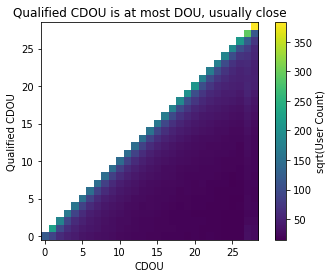

In [14]:
plt.imshow(np.sqrt(CDOU_QCDOU_counts), cmap='viridis')
plt.colorbar(label='sqrt(User Count)')
plt.xlabel('CDOU')
plt.ylabel('Qualified CDOU')
plt.gca().invert_yaxis()
plt.title('Qualified CDOU is at most DOU, usually close')
plt.show()

In [15]:
df.loc[:, 'abs_diff'] = df.days_of_use - df.qualified_cumulative_days_of_use

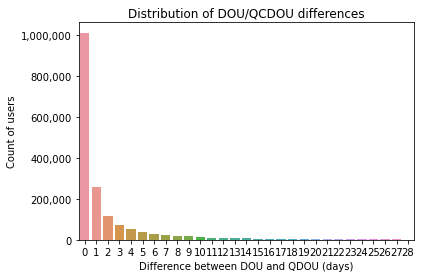

In [16]:
diff_counts = df.abs_diff.value_counts()
sns.barplot(x=diff_counts.index, y=diff_counts)
plt.xlabel('Difference between DOU and QDOU (days)')
plt.ylabel('Count of users')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title('Distribution of DOU/QCDOU differences')
plt.show()

In [17]:
df.loc[:, 'pct_diff'] = (df.days_of_use - df.qualified_cumulative_days_of_use)/df.days_of_use

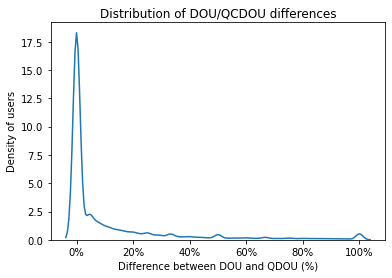

In [18]:
sns.kdeplot(df.pct_diff)
plt.xlabel('Difference between DOU and QDOU (%)')
plt.ylabel('Density of users')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.title('Distribution of DOU/QCDOU differences')
plt.show()

In [19]:
(df.pct_diff * 100).quantile([0.5, 0.6, 0.7, 0.8, 0.9])

0.5     0.000000
0.6     3.846154
0.7     8.695652
0.8    19.230769
0.9    42.857143
Name: pct_diff, dtype: float64

In [20]:
experiment_reanalysis_query = '''
SELECT *
FROM `moz-fx-data-bq-data-science.dberry.statistics_more_from_mozilla_96_overall_1` 
WHERE (metric = 'days_of_use' or metric = 'qualified_cumulative_days_of_use') and (statistic = 'mean')
'''

In [21]:
experiment_reanalysis_metrics = bq_client.table_to_dataframe('statistics_more_from_mozilla_96_overall_1')

## Validate that metrics below align with Nimbus console results
![Metrics from Nimbus Console](mfm_96_prod.png)

In [22]:
metrics_vs_prod = ((
    experiment_reanalysis_metrics
    .loc[(
        experiment_reanalysis_metrics.metric.isin(['days_of_use', 'search_count']) & 
        (experiment_reanalysis_metrics.statistic == 'mean') &
        (experiment_reanalysis_metrics.comparison == 'relative_uplift')
    )]
    .reset_index(drop = True)
    .sort_values(['branch', 'metric'], ascending = [True, False])
    [['metric', 'lower', 'upper']]
    *100)
    .round(1)
)

In [23]:
metrics_vs_prod

,metric,lower,upper
0,search_countsearch_countsearch_countsearch_cou...,-0.7,0.7
3,days_of_usedays_of_usedays_of_usedays_of_useda...,-0.2,0.2
1,search_countsearch_countsearch_countsearch_cou...,-0.9,0.5
2,days_of_usedays_of_usedays_of_usedays_of_useda...,-0.3,0.1


In [24]:
metrics_of_interest = (
    experiment_reanalysis_metrics
    .loc[(
        experiment_reanalysis_metrics.metric.isin(['days_of_use', 'qualified_cumulative_days_of_use']) & 
        (experiment_reanalysis_metrics.statistic == 'mean')
    )]
    .reset_index(drop = True)
)

# Compare CIs for raw metrics by branch

In [25]:
get_index = lambda col: np.where(metrics_of_interest.columns == col)[0][0]
lower_index = get_index('lower')
point_index = get_index('point')
upper_index = get_index('upper')
branch_index = get_index('branch')

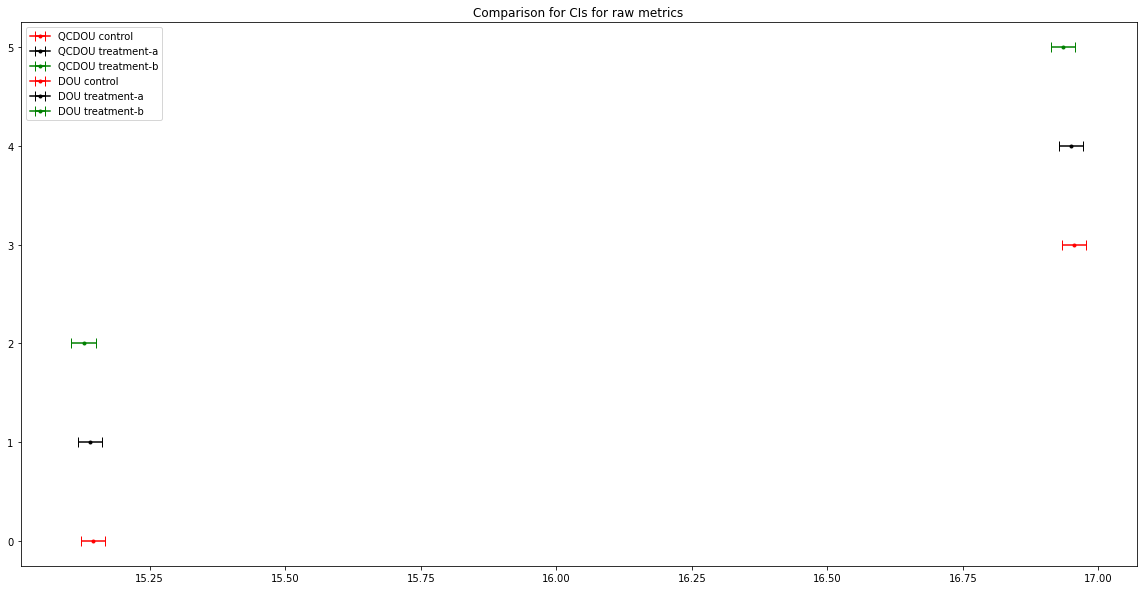

In [26]:
fig, ax = plt.subplots(figsize = (20,10))
for metric_row,color in zip(range(3),['r','k','g']):
    plt.errorbar(
        x = metrics_of_interest.iloc[metric_row,point_index], 
        y = metric_row, 
        xerr=metrics_of_interest.iloc[metric_row,upper_index] - metrics_of_interest.iloc[metric_row, point_index], 
        label = 'QCDOU ' + metrics_of_interest.iloc[metric_row, branch_index], 
        color = color,
        marker = '.',
        capsize = 5
    )
    
for metric_row,color in zip(range(3,6),['r','k','g']):
    plt.errorbar(
        x = metrics_of_interest.iloc[metric_row,point_index], 
        y = metric_row, 
        xerr=metrics_of_interest.iloc[metric_row,upper_index] - metrics_of_interest.iloc[metric_row, point_index], 
        label = 'DOU ' + metrics_of_interest.iloc[metric_row, branch_index], 
        color = color,
        marker = '.',
        capsize = 5
    )    
plt.title('Comparison for CIs for raw metrics')
plt.legend()
plt.show()

# Compare CIs for absolute differences

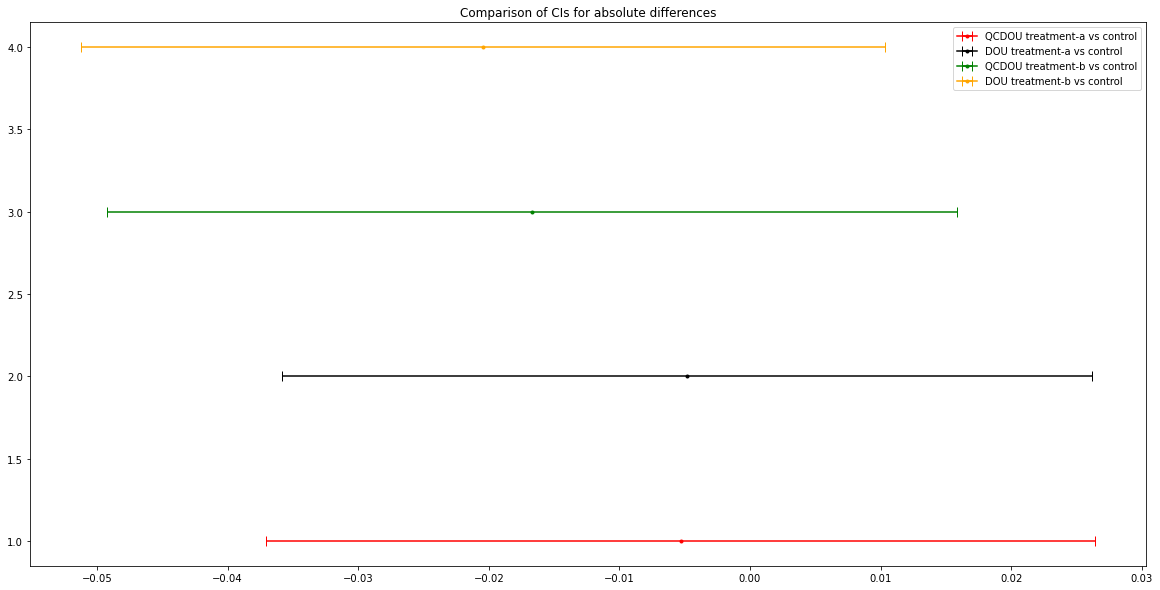

In [27]:
fig, ax = plt.subplots(figsize = (20,10))
for metric_row, y_plot, color, metric_basis in zip([6,9],[1,2],['r','k'],['QCDOU', 'DOU']):
    plt.errorbar(
        x = metrics_of_interest.iloc[metric_row,point_index], 
        y = y_plot, 
        xerr=metrics_of_interest.iloc[metric_row,upper_index] - metrics_of_interest.iloc[metric_row, point_index], 
        label = metric_basis + ' ' + metrics_of_interest.iloc[metric_row, branch_index] + ' vs control', 
        color = color,
        marker = '.',
        capsize = 5
    )
    
for metric_row, y_plot, color, metric_basis in zip([7,8],[3,4],['g','orange'],['QCDOU', 'DOU']):
    plt.errorbar(
        x = metrics_of_interest.iloc[metric_row,point_index], 
        y = y_plot, 
        xerr=metrics_of_interest.iloc[metric_row,upper_index] - metrics_of_interest.iloc[metric_row, point_index], 
        label = metric_basis + ' ' + metrics_of_interest.iloc[metric_row, branch_index] + ' vs control', 
        color = color,
        marker = '.',
        capsize = 5,
    )    
plt.title('Comparison of CIs for absolute differences')
plt.legend()
plt.show()

# Compare CIs for relative differences

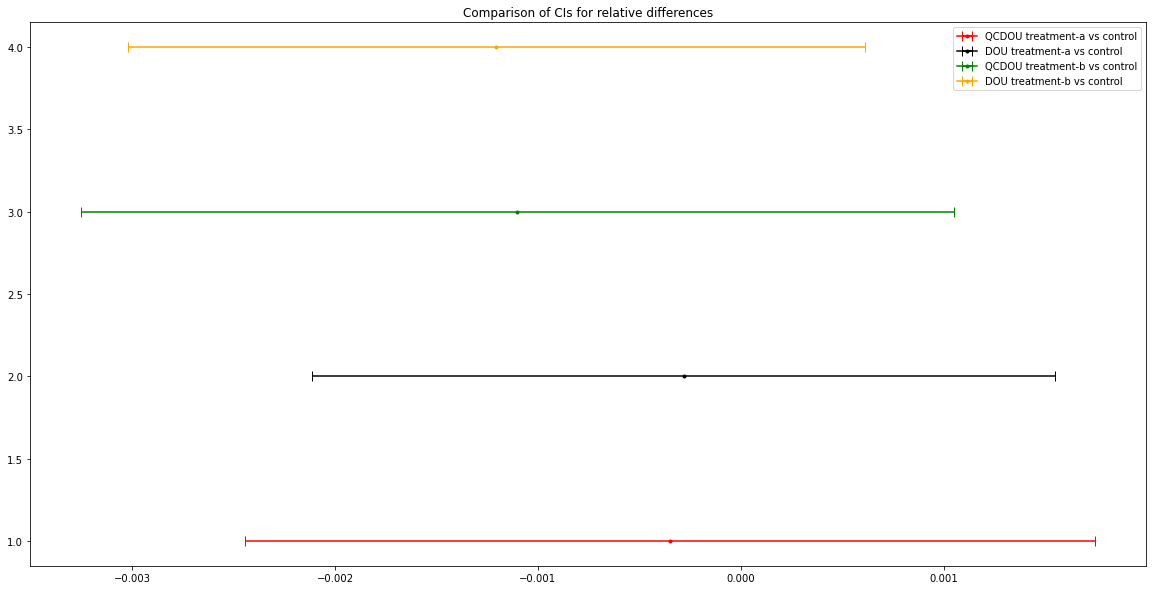

In [28]:
fig, ax = plt.subplots(figsize = (20,10))
for metric_row, y_plot, color, metric_basis in zip([10,13],[1,2],['r','k'],['QCDOU', 'DOU']):
    plt.errorbar(
        x = metrics_of_interest.iloc[metric_row,point_index], 
        y = y_plot, 
        xerr=metrics_of_interest.iloc[metric_row,upper_index] - metrics_of_interest.iloc[metric_row, point_index], 
        label = metric_basis + ' ' + metrics_of_interest.iloc[metric_row, branch_index] + ' vs control', 
        color = color,
        marker = '.',
        capsize = 5
    )
    
for metric_row, y_plot, color, metric_basis in zip([11,12],[3,4],['g','orange'],['QCDOU', 'DOU']):
    plt.errorbar(
        x = metrics_of_interest.iloc[metric_row,point_index], 
        y = y_plot, 
        xerr=metrics_of_interest.iloc[metric_row,upper_index] - metrics_of_interest.iloc[metric_row, point_index], 
        label = metric_basis + ' ' + metrics_of_interest.iloc[metric_row, branch_index] + ' vs control', 
        color = color,
        marker = '.',
        capsize = 5
    )    
plt.title('Comparison of CIs for relative differences')
plt.legend()
plt.show()